In [95]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt

EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)
eeg_data_epoch.shape: (64, 206, 99) eeg_data_epoch_20.shape (64, 216, 99)


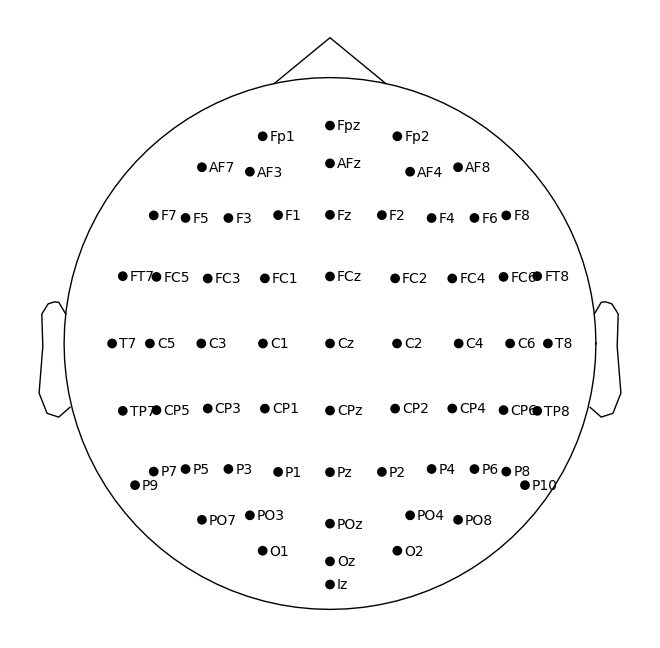

C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\153449361.py:96: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


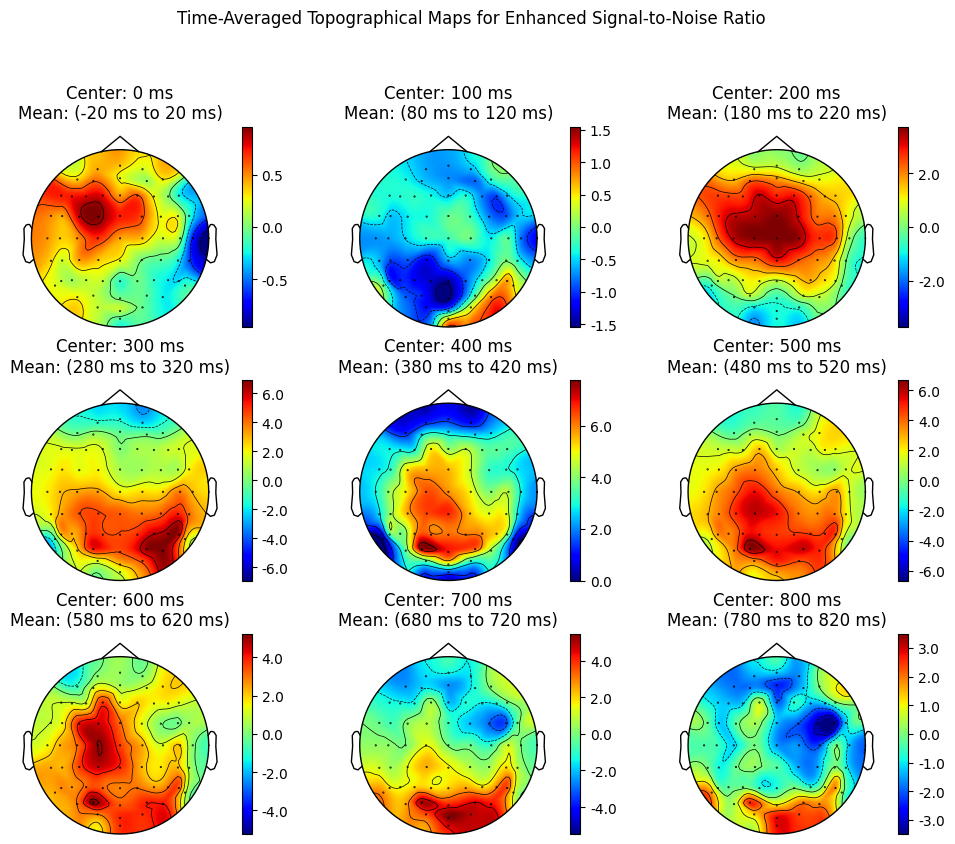

AVE_ERP_np.shape (9, 64)


C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\153449361.py:120: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


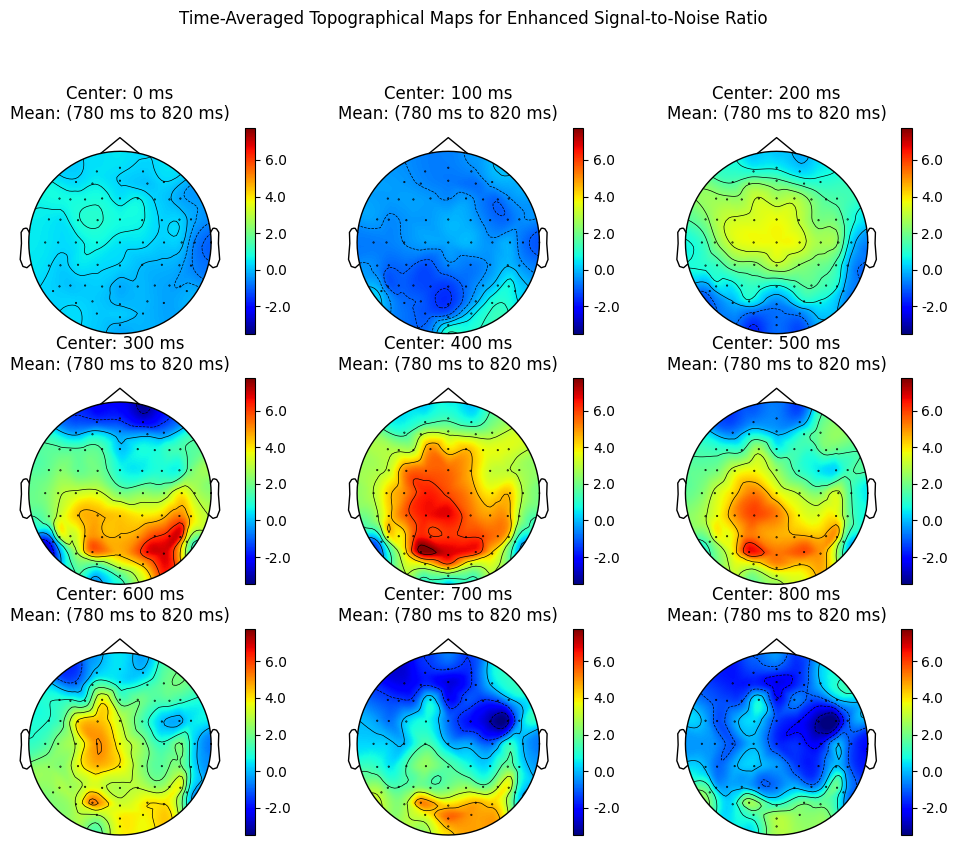

AVE_ERP_np.shape (9, 64)


In [165]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
# Extract EEG data
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)

# a.1. Extract Epochs from 0 to 800 ms
# Given a sampling rate of 256 Hz, the time interval between two consecutive samples is 1/256 = 3.90625 ms. (I consider 4ms for each sample point)
# Thus, 0 ms corresponds to the sample point at index 256, 
# and 800 ms corresponds to the sample point at index (800 / 3.90625) = 256+204.8=460.8, which can be rounded to 461.

eeg_data_epoch= eeg_data[:, 256:462, :]# eeg_data_epoch.shape: (64, 206, 99), 256:462:
#This indexes elements from the 256th to the 461st along the second dimension(since Python indexing is 0-based and the stop value in a slice is exclusive).
eeg_data_epoch_20= eeg_data[:, 251:467, :] # eeg_data_epoch_20.shape:(64, 216, 99)

print('eeg_data_epoch.shape:', eeg_data_epoch.shape, 'eeg_data_epoch_20.shape', eeg_data_epoch_20.shape )

# Compute the ERP at each electrode by averaging across all trials
ERP = np.mean(eeg_data_epoch, axis=2) # shape: (64, 206)
ERP_20 = np.mean(eeg_data_epoch_20, axis=2) # shape: (64, 216)


##############################
# # Read the file content
# with open('eloc64C2.txt', 'r') as f:
#     lines = f.readlines()
# # Extract channel names, theta, and radius
# channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
# theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
# radius = np.array([float(line.split()[2]) for line in lines[0:]])
# # Convert polar to Cartesian
# x = radius * np.cos(theta)/5
# y = -radius * np.sin(theta)/5
# z = np.zeros_like(x)  # default z-coordinate for all channels
# # Create a montage
# ch_pos = dict(zip(channel_names, zip(x, y, z)))
# montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
# info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# # Apply the montage to the info
# info.set_montage(montage)
###########################

# Create a standard 64-channel BioSemi montage
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_coords_3d = montage.get_positions()['ch_pos'] # Get 3D coordinates
# If you need to convert the 3D coordinates to 2D for some reason (for example, for plotting on a 2D plane), 
# you can potentially just take the X and Y coordinates and ignore Z. However, keep in mind this is an approximation.
channel_coords = [(x, y) for x, y, _ in channel_coords_3d.values()]
# Create Info object and set montage
# The info variable typically contains metadata about the EEG data, such as the sampling rate, channel names, channel types, etc
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)


# Create an evoked object
# The evoked object is an instance of the EvokedArray class in MNE, which is useful for visualization and further processing in the MNE ecosystem.
#ERP: It is a 2D numpy array that contains the event-related potential values. This is a simple numeric representation with dimensions corresponding to channels and time points.
#evoked: It is an object of type EvokedArray that wraps around the ERP numpy array. It integrates the numeric ERP data with metadata (info)
#and provides various methods and attributes for easier visualization and analysis of the data in the context of the MNE-Python library. 
evoked = mne.EvokedArray(ERP, info)
evoked_20 = mne.EvokedArray(ERP_20, info)

# a.2. Plot the topographical map
# The evoked.plot_topomap() function from the MNE-Python library is used to plot topographical maps of EEG data, 
# giving a spatial representation of voltage (or other measures) across the scalp at specific points in time.
# evoked.plot_topomap(times=np.linspace(0, .8, 9), nrows=3, ncols=3, size=1, cmap='jet', time_unit='s', show=False)
# plt.suptitle("Time-Averaged Across All Trials (without averaging the activity from 20 ms before to 20 ms after each time point.)")
# plt.show()

# Plot the sensor locations
#When you're plotting EEG channels with plot_sensors, MNE sometimes creates two plots: one for a top-down view and another for a side view,
# especially when 3D channel locations (with both horizontal and vertical coordinates) are present.
#You can suppress the side view by setting the proj argument to True:
evoked.plot_sensors(kind='topomap', show_names=True, ch_type='eeg')

# a. Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio
# Close any existing plots
plt.close('all')
# Define center times 
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
# Create a figure to hold the subplots
fig, axs = plt.subplots(3, 3, figsize=(10,8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.05)
# Now plot the topomaps
AVE_ERP=[]
for idx, center_time in enumerate(center_times):
    # Define the time window around the center time: 20 ms before and after
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    # Crop the data around this time window and compute the average
    avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP.append(avg_data)
    # Create a subplot for this topographical map
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data, evoked_20.info, cmap='jet', axes=ax, show=False)
    # Manually add colorbar to each plot
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical') 
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
AVE_ERP_np=np.array(AVE_ERP)
print('AVE_ERP_np.shape', AVE_ERP_np.shape) #(9,64)


# a. Make the colormaps in ‘jet’ format and keep the color limit for all the topoplots for each section the same
plt.close('all')
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.05)
AVE_ERP = []
# First, gather all averaged data
for center_time in center_times:
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP.append(avg_data)
AVE_ERP_np = np.array(AVE_ERP)
global_vmin, global_vmax = AVE_ERP_np.min(), AVE_ERP_np.max()
for idx, center_time in enumerate(center_times):
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(AVE_ERP_np[idx, :], evoked_20.info, cmap='jet', axes=ax, show=False)
    # Adjust the color limits to reflect the global max and min
    im.set_clim(global_vmin, global_vmax)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical')
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
print('AVE_ERP_np.shape', AVE_ERP_np.shape)  # (9, 64)

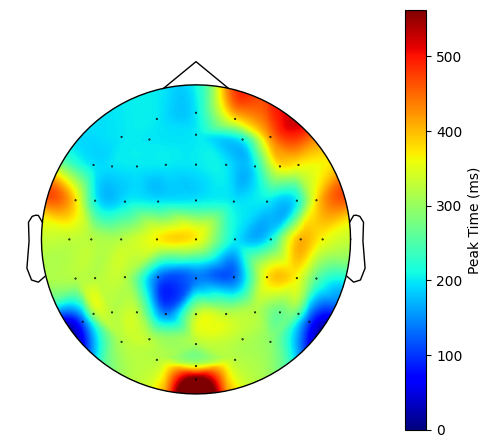

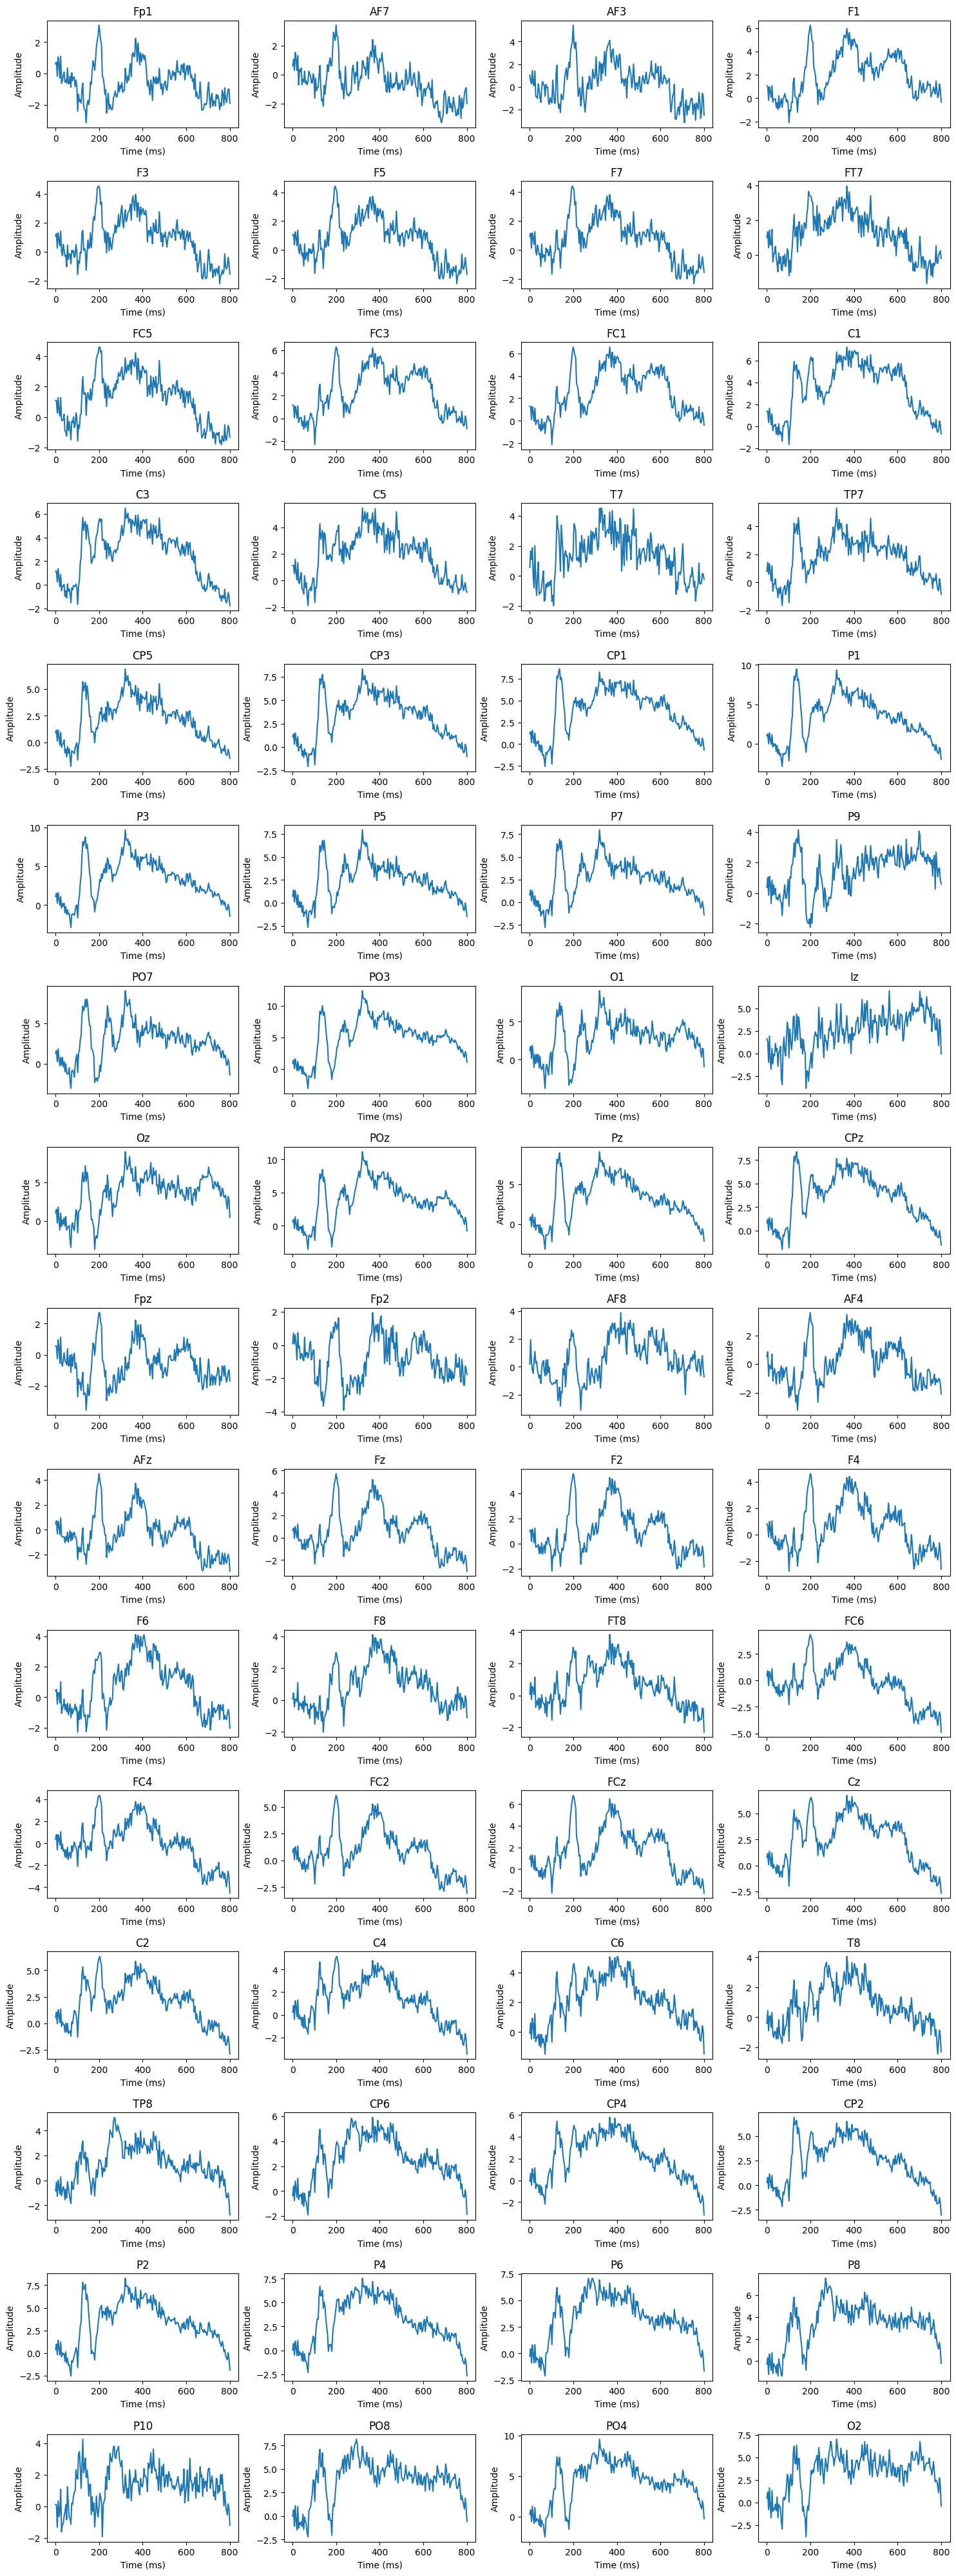

In [168]:
# b. 
times = evoked.times
# print('times:', times, 'times.shape', times.shape) # [0.         0.00390625, ..., 0.80078125], times.shape (206,)
max_values = []
max_times = []
for i in range(ERP.shape[0]):
    max_val = np.max(ERP[i, :])
    max_idx = np.argmax(ERP[i, :])
    max_values.append(max_val)
    max_times.append(times[max_idx])
max_values = np.array(max_values)
max_times = np.array(max_times) * 1000  # Convert to milliseconds
# Topographical plot of the peak times with larger figsize
fig, ax = plt.subplots(figsize=(6,5))
im, _ = mne.viz.plot_topomap(max_times, evoked.info, cmap='jet', contours=0, axes=ax, show=False, size=3)
# Show colorbar
plt.colorbar(im, ax=ax, label='Peak Time (ms)')
plt.show()
# Create a figure with 64 subplots (16 rows and 4 columns)
fig, axs = plt.subplots(nrows=16, ncols=4, figsize=(15, 40))
fig.tight_layout(pad=2.0)  # Adjust the spacing between subplots
# Flatten the axis array for easier indexing
axs = axs.ravel()
for idx in range(64):  # Loop through each channel
    # Plot the ERP data for the current channel over time
    axs[idx].plot(times * 1000, ERP[idx, :])
    axs[idx].set_title(evoked.ch_names[idx])  # Set title as channel name
    axs[idx].set_xlabel('Time (ms)')
    axs[idx].set_ylabel('Amplitude')
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()


In [162]:
# with open('eloc64C2.txt', 'r') as f:
#     lines = f.readlines()
# # Extract channel names, theta, and radius
# channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
# theta = np.array([float(line.split()[1]) for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
# radius = np.array([float(line.split()[2]) for line in lines[0:]])
# # Convert polar to Cartesian
# x = radius * np.cos(theta)
# y = -radius * np.sin(theta)
# z = np.zeros_like(x)  # default z-coordinate for all channels
# # Create a montage
# ch_pos = dict(zip(channel_names, zip(x, y, z)))
# montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
# info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# # Apply the montage to the info
# info.set_montage(montage)

evoked_lap = evoked_20
evoked_lap.set_montage(montage)
xyz_coords = np.array([ch['loc'][:3] for ch in evoked_lap.info['chs']])

C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\2751846106.py:43: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data_lap= evoked_filtered.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


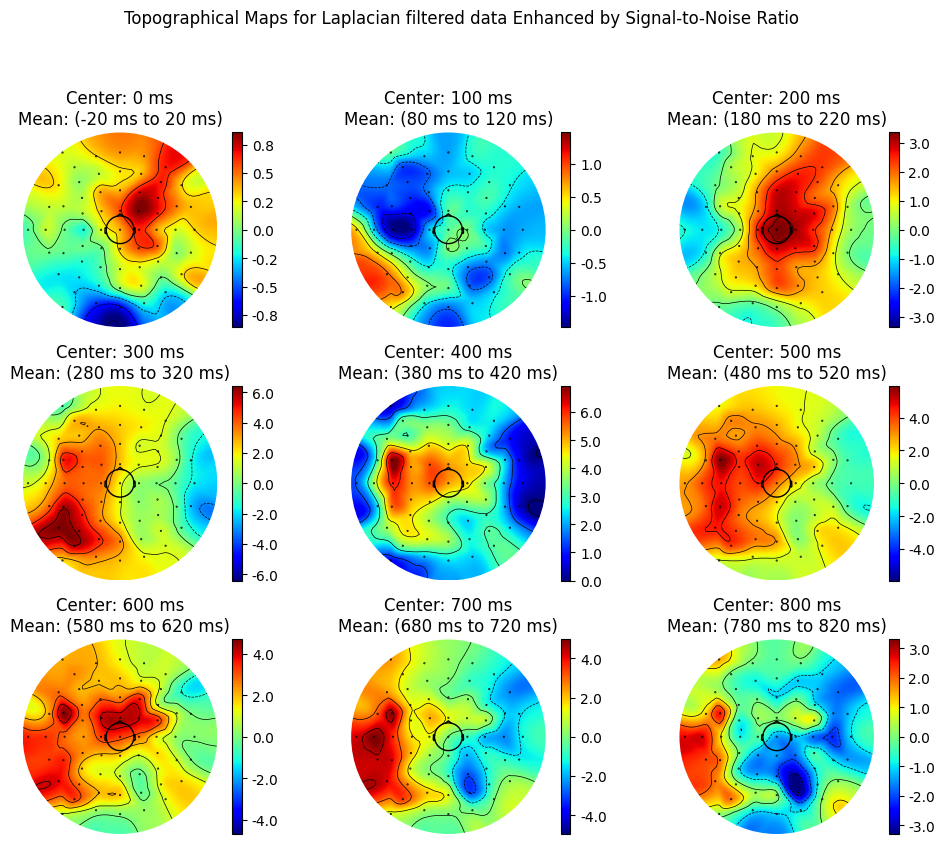

AVE_ERP_lap_np.shape (9, 64)


C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\2751846106.py:66: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


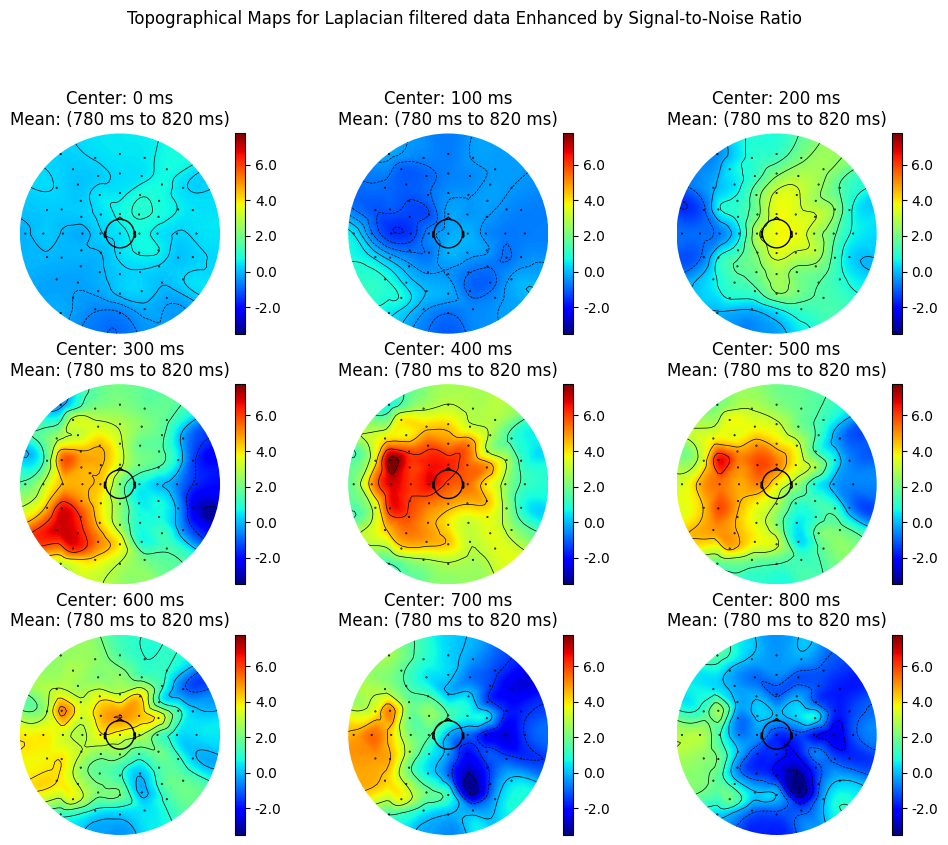

AVE_ERP_np.shape (9, 64)


In [163]:
# c. 
# Steps of achieve the Laplacian filtering in Python using the MNE library:
# 1. Convert the electrode locations to Cartesian coordinates.
# 2- Compute the Euclidean distances between each pair of electrodes.
# 3. Filter the distances to keep those within the range [0.18, 0.28].
# 4. Compute the filter weights.
# 5. Apply the Laplacian filter to the EEG data.
##################################################################################
# Read the file content
# 2. Compute pairwise Euclidean distances
eucdist = np.linalg.norm(xyz_coords[:, np.newaxis] - xyz_coords, axis=2)
# 3. Filter the distances
lo_width = 0.18
hi_width = 0.28
filtered_indices = np.where((eucdist > lo_width) & (eucdist < hi_width))
# 4. Compute filter weights
weights = np.zeros_like(eucdist)
for i, j in zip(*filtered_indices):
    weights[i, j] = (1 / eucdist[i, j]) / np.sum(1 / eucdist[i, eucdist[i, :] > 0])
# 5. Apply the Laplacian filter
data = evoked_lap.data
laplacian_filtered_data = np.zeros_like(data)
for i in range(data.shape[1]):
    laplacian_filtered_data[:, i] = data[:, i] - np.dot(weights, data[:, i])
# Create a new Evoked object with the filtered data 
evoked_filtered = mne.EvokedArray(laplacian_filtered_data, evoked_lap.info)

# evoked_filtered.plot_sensors(kind='topomap', show_names=True, ch_type='eeg')

plt.close('all')
# Define center times 
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
# Create a figure to hold the subplots
fig, axs = plt.subplots(3, 3, figsize=(10,8))
fig.suptitle("Topographical Maps for Laplacian filtered data Enhanced by Signal-to-Noise Ratio", fontsize=12, y=1.05)
# Now plot the topomaps
AVE_ERP_lap=[]
for idx, center_time in enumerate(center_times):
    # Define the time window around the center time: 20 ms before and after
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    # Crop the data around this time window and compute the average
    avg_data_lap= evoked_filtered.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP_lap.append(avg_data_lap)
    # Create a subplot for this topographical map
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data_lap, evoked_filtered .info, cmap='jet', axes=ax, show=False)
    # Manually add colorbar to each plot
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical') 
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
AVE_ERP_lap_np=np.array(AVE_ERP_lap)
print('AVE_ERP_lap_np.shape', AVE_ERP_lap_np.shape) #(9,64)

# a. Make the colormaps in ‘jet’ format and keep the color limit for all the topoplots for each section the same
plt.close('all')
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Topographical Maps for Laplacian filtered data Enhanced by Signal-to-Noise Ratio", fontsize=12, y=1.05)
AVE_ERP = []
# First, gather all averaged data
for center_time in center_times:
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP.append(avg_data)
AVE_ERP_np = np.array(AVE_ERP)
global_vmin, global_vmax = AVE_ERP_np.min(), AVE_ERP_np.max()
for idx, center_time in enumerate(center_times):
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(AVE_ERP_np[idx, :], evoked_20.info, cmap='jet', axes=ax, show=False)
    # Adjust the color limits to reflect the global max and min
    im.set_clim(global_vmin, global_vmax)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical')
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
print('AVE_ERP_np.shape', AVE_ERP_np.shape)  # (9, 64)